### chr10 core-cenhap analysis
In this notebook, normalized counts of cenhap-specific k-mers are used to train a Random Forest classifier, with each cenhap treated as an independent target in a multi-label classification setting.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score

# Train model

In [2]:
# Set names of clade-specific kmers
h1_kmer = 'cen10h1'
h2_kmer = 'cen10h2'

In [3]:
# Load and normalize input k-mer count data in 1000 Genomes
raw_counts = pd.read_csv('inputs/modern_counts.tsv', sep='\t').set_index('id')
norm_counts = raw_counts.div(raw_counts[h1_kmer] + raw_counts[h2_kmer], axis=0)

# select kmers for prediction
selected_kmers = ['ch1-1', 'ch1-2', 'ch2', 'ch3,5', 'ch4', 'ch6', 'ch7', 'ch8', 'ch9', 'ch13']
norm_counts = norm_counts.loc[:, selected_kmers]

# Load haplotype labels
metadata = pd.read_csv('inputs/metadata.tsv', sep='\t').set_index('id')
flank_cenhaps = metadata[['mat_cenhap', 'pat_cenhap']].dropna().map(lambda x: str(int(x)))
number_of_cenhaps = len(set(np.concatenate((flank_cenhaps['mat_cenhap'], flank_cenhaps['pat_cenhap']))))

# Keep only samples with haplotype assignments
norm_counts = norm_counts.loc[flank_cenhaps.index]

In [4]:
# Encode haplotype targets and split the dataset
hap_classes = [str(i) for i in range(1, number_of_cenhaps+1)]
mlb = MultiLabelBinarizer(classes=hap_classes)
Y = mlb.fit_transform(flank_cenhaps.values)
X = norm_counts.values

# train/test split
X_train, X_test, y_train, y_test, idx_train, idx_test = train_test_split(
    X, Y, norm_counts.index, test_size=0.2, random_state=42
)

# add train/test status of sample to metadata
metadata.loc[idx_train, 'subsample'] = 'train'
metadata.loc[idx_test, 'subsample'] = 'test'

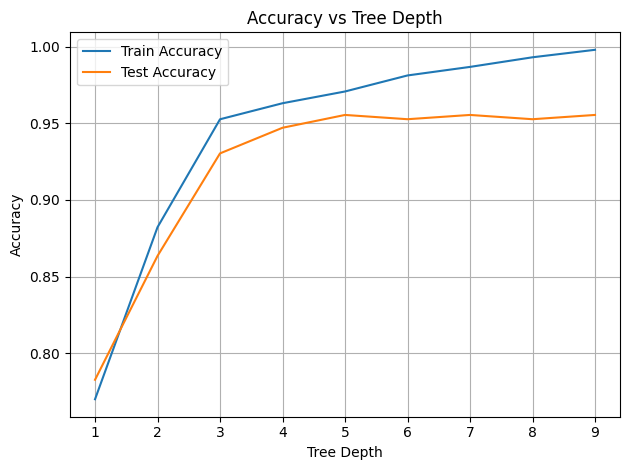

In [5]:
# Plot accuracy vs tree depth to detect overfitting
depths = list(range(1, 10))
train_acc = []
test_acc = []

for depth in depths:
    clf = MultiOutputClassifier(RandomForestClassifier(max_depth=depth, n_estimators=100, random_state=42))
    clf.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, clf.predict(X_train)))
    test_acc.append(accuracy_score(y_test, clf.predict(X_test)))

plt.plot(depths, train_acc, label='Train Accuracy')
plt.plot(depths, test_acc, label='Test Accuracy')
plt.xlabel('Tree Depth')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Tree Depth')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Let's pick depth 5 for not to get too overfit

In [6]:
# Train final model with chosen depth and evaluate accuracy
model = MultiOutputClassifier(RandomForestClassifier(max_depth=5, n_estimators=100, random_state=42))
model.fit(X_train, y_train)

y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train accuracy: {train_acc:.4f}")
print(f"Test accuracy: {test_acc:.4f}")

Train accuracy: 0.9707
Test accuracy: 0.9554


In [7]:
# Compute and display feature importance table
importances = np.mean([est.feature_importances_ for est in model.estimators_], axis=0)
feature_importance = pd.DataFrame({
    'kmer': norm_counts.columns,
    'importance': importances
}).sort_values(by='importance', ascending=False)
feature_importance

,kmer,importance
9,ch13,0.125628
8,ch9,0.117213
4,ch4,0.109986
7,ch8,0.105427
5,ch6,0.104928
3,"ch3,5",0.103550
0,ch1-1,0.095883
2,ch2,0.082659
6,ch7,0.081804
1,ch1-2,0.072923


# Predict core-cenhaps

### Prediction function

In [8]:
# Prediction function
def predict_core_cenhap(path_to_counts_file):

    # Load counts
    raw_counts = pd.read_csv(path_to_counts_file, sep='\t').set_index('id')

    # Normalize counts by h1_kemr + h2_kmer
    norm_counts = raw_counts.div(raw_counts[h1_kmer] + raw_counts[h2_kmer], axis=0)

    # select kmers for prediction
    norm_counts = norm_counts.loc[:, selected_kmers]
    
    # Predict using the trained model
    X_new = norm_counts[norm_counts.columns].values
    y_pred = model.predict(X_new)
    
    # Convert to string labels
    core_cenhaps = pd.DataFrame(index=raw_counts.index)
    pred_labels = mlb.inverse_transform(y_pred)
    core_cenhaps['core_cenhap'] = [','.join(sorted(haps)) for haps in pred_labels]

    # Get class probabilities
    y_proba = model.predict_proba(X_new)
    for i in range(len(y_pred)):
        core_cenhaps_index = core_cenhaps.index[i]
        probs = []
        for cenhap_index in np.where(y_pred[i] == 1)[0]:
            cenhap_prob = str(round(y_proba[cenhap_index][i][1], 3))
            probs.append(cenhap_prob)
        probs = ', '.join(probs)
        core_cenhaps.loc[core_cenhaps_index, 'prob'] = probs

    # homoygots predictions 'n' --> 'n,n'
    core_cenhaps['core_cenhap'] = core_cenhaps['core_cenhap'].astype(str).apply(
        lambda x: f"{x},{x}" if ',' not in x else x
    )

    return raw_counts, (norm_counts*100).round(5), core_cenhaps

### Modern samples analysis

In [9]:
# predict all 3202 1000 Genomes samples
raw_counts, norm_counts, core_cenhaps = predict_core_cenhap('inputs/modern_counts.tsv')

# convert flank-cenhaps to match core-cenhaps format
flank_cenhaps['flank_cenhap'] = flank_cenhaps[['mat_cenhap', 'pat_cenhap']].apply(
    lambda row: ','.join(map(str, sorted([row['mat_cenhap'], row['pat_cenhap']]))), axis=1
)

# concatinate flank-cenhaps and core-cenhaps
cenhaps = pd.concat([flank_cenhaps[['flank_cenhap']], core_cenhaps], axis=1)

# check errors
cenhaps_half = cenhaps.dropna()
cenhaps_half['match'] = cenhaps_half['flank_cenhap'] == cenhaps_half['core_cenhap']
mismatches = cenhaps_half[cenhaps_half['match'] == False]
print(f'Total accuracy: {round(1 - len(mismatches) / len(cenhaps_half), 3)}')

Total accuracy: 0.968


/tmp/ipykernel_58999/722629435.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cenhaps_half['match'] = cenhaps_half['flank_cenhap'] == cenhaps_half['core_cenhap']


In [10]:
# mismatches frequency table
cnt_mismatches = Counter(mismatches['flank_cenhap'] + '_' + mismatches['core_cenhap'])
cnt_mismatches = pd.DataFrame(cnt_mismatches, index=['cnt']).T.sort_values('cnt', ascending=False)
cnt_mismatches.to_csv('outputs/mismatches_stats.tsv', sep='\t')
cnt_mismatches.head()

,cnt
"2,3_2,2",8
"3,3_2,3",7
"10,2_2,2",6
"2,5_2,3",5
"13,2_2,2",3


In [11]:
# create final resulting table

# h1h2 counts
h1h2_kmers = raw_counts[[h1_kmer, h2_kmer]].div(raw_counts[h1_kmer] + raw_counts[h2_kmer], axis=0).round(5)

# assemble resulting table
modern_results = pd.concat([metadata, cenhaps, cenhaps_half['match'], h1h2_kmers, norm_counts], axis=1).sort_index()

# fix types
modern_results['mat_cenhap'] = modern_results['mat_cenhap'].apply(pd.to_numeric, errors='coerce').astype('Int64')
modern_results['pat_cenhap'] = modern_results['pat_cenhap'].apply(pd.to_numeric, errors='coerce').astype('Int64')

# save table
modern_results.to_csv('outputs/modern_results.tsv', sep='\t')
modern_results.head()

,asm,sex,Family status,Superpop,Population,mat_cenhap,pat_cenhap,mat ch new,pat ch new,subsample,...,ch1-1,ch1-2,ch2,"ch3,5",ch4,ch6,ch7,ch8,ch9,ch13
id,,,,,,,,,,,,,,,,,,,,,
HG00096,HGSVC,male,proband,EUR,GBR,<NA>,<NA>,NaN,NaN,NaN,...,0.22485,0.01030,2.48541,0.00172,0.14761,0.00172,0.01030,0.06694,0.06351,28.70065
HG00097,YR4,female,proband,EUR,GBR,<NA>,<NA>,NaN,NaN,NaN,...,0.00000,0.01705,0.64377,6.09239,44.20072,0.00213,0.01492,0.07674,0.05756,0.02558
HG00099,YR3,female,proband,EUR,GBR,<NA>,<NA>,NaN,NaN,NaN,...,0.10918,0.02153,1.16717,0.03383,37.58938,0.01076,0.01230,0.06920,0.03691,16.81865
HG00100,NaN,female,proband,EUR,GBR,<NA>,<NA>,NaN,NaN,NaN,...,0.26204,0.01008,25.29076,0.00403,0.12497,0.00202,0.01814,0.07055,0.02217,16.24035
HG00101,NaN,male,proband,EUR,GBR,<NA>,<NA>,NaN,NaN,NaN,...,0.08811,0.02291,1.67413,11.08624,0.09692,0.00352,0.01762,0.06873,0.08283,8.67374


### Archaic samples analysis

In [12]:
raw_counts, norm_counts, core_cenhaps = predict_core_cenhap('inputs/archaic_counts.tsv')

In [13]:
# h1h2 counts
h1h2_kmers = raw_counts[[h1_kmer, h2_kmer]].div(raw_counts[h1_kmer] + raw_counts[h2_kmer], axis=0).round(5)

# resulting table
archaic_results = pd.concat([core_cenhaps, h1h2_kmers, norm_counts], axis=1)
archaic_results.to_csv('outputs/archaic_results.tsv', sep='\t')
archaic_results

,core_cenhap,prob,cen10h1,cen10h2,ch1-1,ch1-2,ch2,"ch3,5",ch4,ch6,ch7,ch8,ch9,ch13
id,,,,,,,,,,,,,,
Denisova,"4,4",0.86,0.05974,0.94026,0.00000,0.00000,0.11325,0.00000,75.08494,0.33975,0.02831,0.16988,0.08494,0.05663
Altai,"4,4",0.812,0.02613,0.97387,0.13927,0.09895,0.87224,0.04764,140.41267,0.31152,0.12094,0.07696,0.18691,0.05131
Chag,"4,4",0.926,0.00000,1.00000,0.00000,0.01654,0.21502,0.08270,55.64009,0.06616,0.03308,0.04962,0.03308,0.00000
Vindija,"4,4",0.827,0.00205,0.99795,0.00000,0.00000,0.00000,0.00000,72.82051,0.10256,0.20513,0.10256,0.10256,0.00000
LesCottes_Z4-1514,"1,4","0.81, 0.645",0.00279,0.99721,5.85679,1.11755,0.30008,0.03104,28.10430,0.05174,0.24834,0.07243,0.04139,0.00000
Mezmaiskaya2,"1,4","0.94, 0.754",0.00478,0.99522,4.97413,1.65141,0.45762,0.00000,24.87067,0.13928,0.09948,0.00000,0.17907,0.13928
Mezmaiskaya1,"1,2,4","0.87, 0.532, 0.836",0.07391,0.92609,2.46350,1.36861,2.09854,0.09124,29.37956,0.00000,0.09124,0.09124,0.00000,0.18248
GoyetQ56-1,"1,1",0.95,0.00366,0.99634,6.59121,2.06356,0.08707,0.04354,0.03483,0.07836,0.18285,0.00000,0.07836,0.06095
Spy94a,"1,1",0.87,0.01236,0.98764,8.61145,1.64813,0.37083,0.16481,0.37083,0.10301,0.14421,0.00000,0.14421,0.02060
